In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from collections import defaultdict
from rmsd_predictor_evaluator import RMSDPredictorEvaluator
from sklearn.metrics import r2_score, mean_squared_error
from rdkit.ML.Scoring.Scoring import CalcBEDROC, CalcEnrichment, CalcAUC, CalcROC
from scipy.stats import pearsonr, spearmanr

In [3]:
a = [0,1,2,3,4]
b = [5,6,7,8,9]

In [5]:
pd.DataFrame(zip(a,b), columns=['key', 'value'])

,key,value
0,0,5
1,1,6
2,2,7
3,3,8
4,4,9


In [2]:
split = 'random'
dataset = 'pdbbind'
iteration = 0
experiment_name = f'{split}_split_{iteration}_v2'
evaluation_name = f'{experiment_name}_{dataset}'
rmsd_predictor_evaluator = RMSDPredictorEvaluator(model=None,
                                                  evaluation_name=evaluation_name)

In [3]:
with open(rmsd_predictor_evaluator.mol_results_path, 'rb') as f:
    mol_results = pickle.load(f)
with open(rmsd_predictor_evaluator.conf_results_path, 'rb') as f:
    conf_results = pickle.load(f)

In [4]:
nha_to_smiles = defaultdict(list)
for smiles, mol_result in mol_results.items() :
    nha = mol_result['n_rotatable_bonds']
    nha_to_smiles[nha].append(smiles)

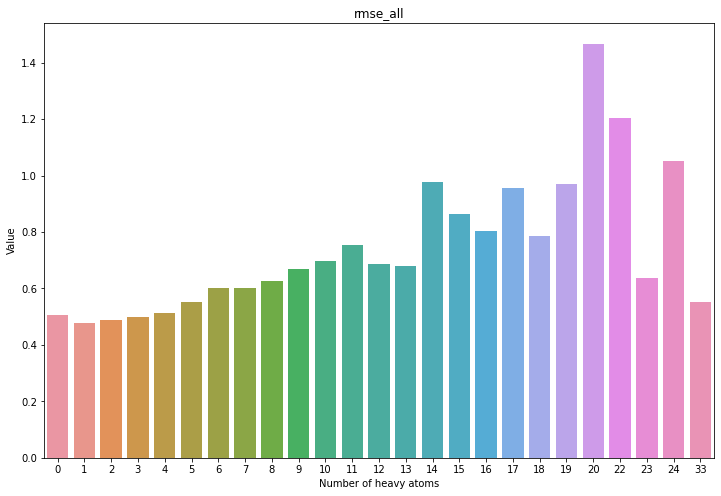

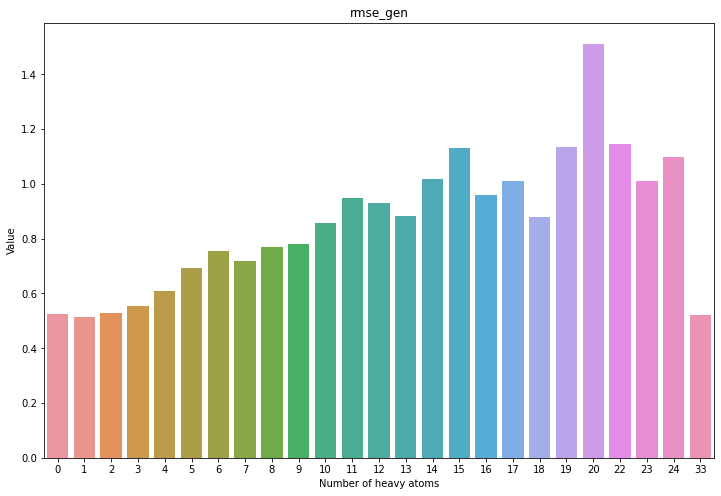

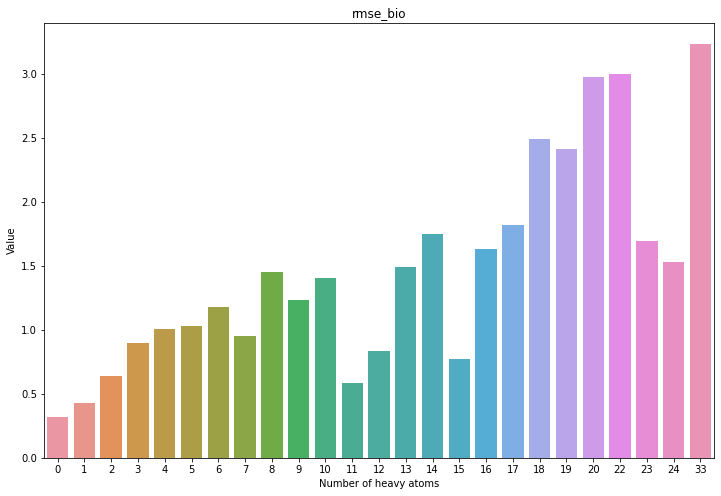

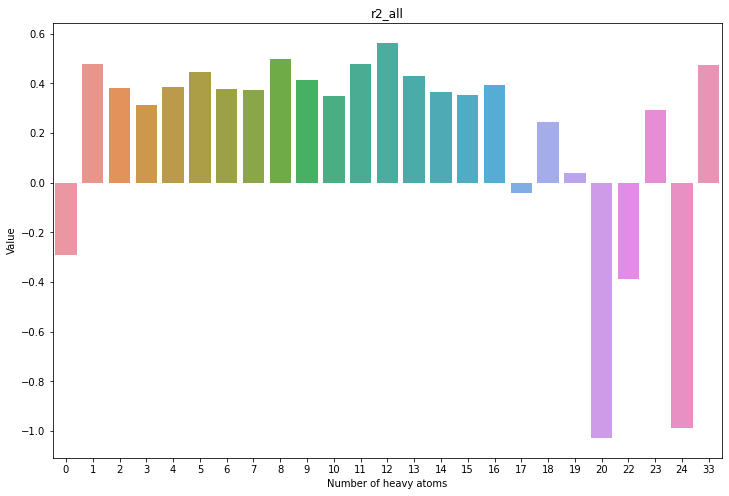

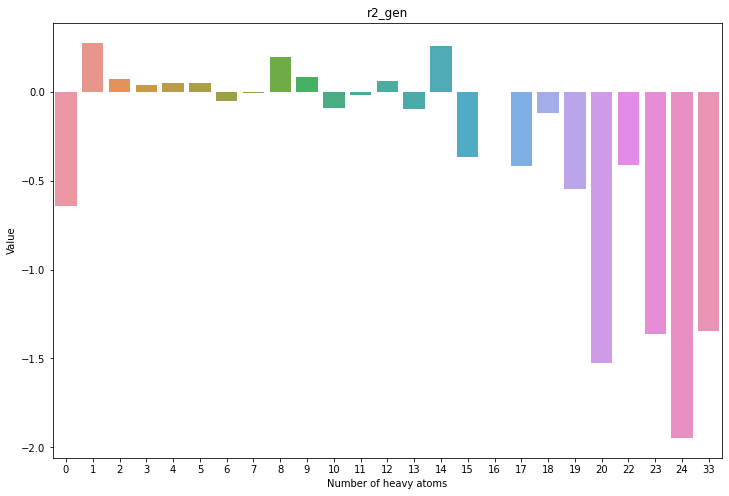

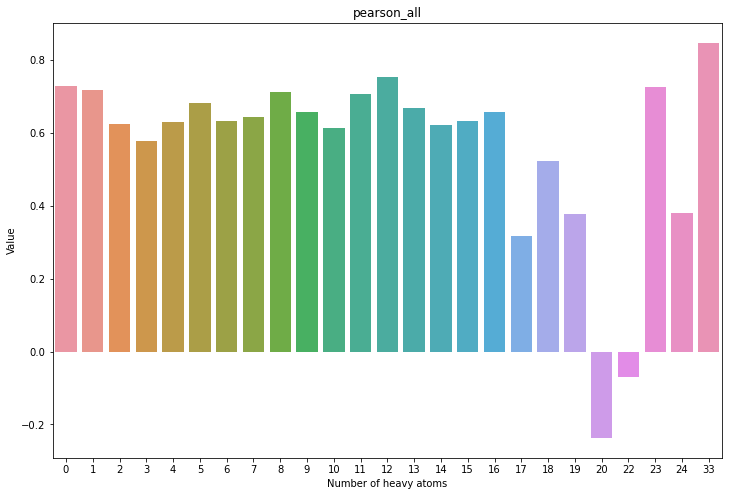

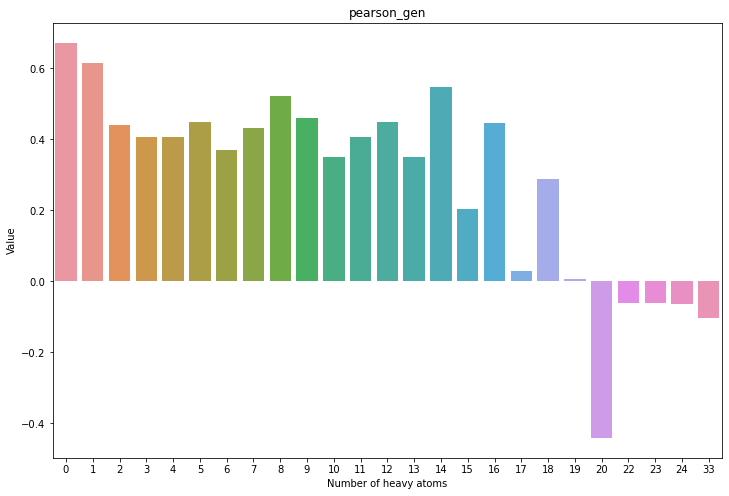

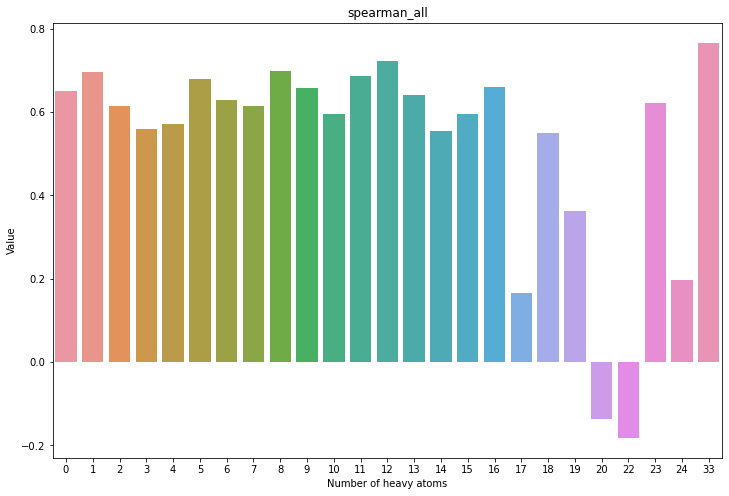

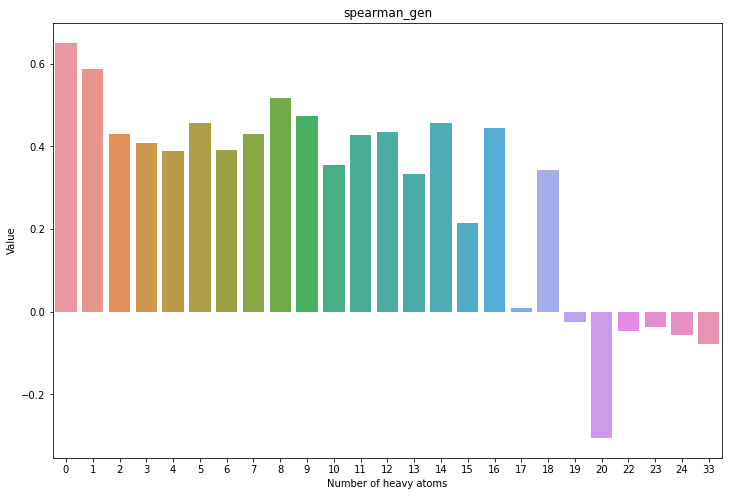

In [5]:
regression_results = {}
for nha in nha_to_smiles :
    nha_results = {}
    for smiles in nha_to_smiles[nha] :
        result = conf_results[smiles]
        nha_results[smiles] = result
      
    if len(nha_results) :
        regression_results[nha] = {}
        
        all_targets = []
        all_preds = []
        all_bioactive_preds = []
        all_generated_targets = []
        all_generated_preds = []
        for smiles, results_d in nha_results.items() :
            if 'bioactive_preds' in results_d :
                all_targets.extend([target for target in results_d['targets']])
                all_preds.extend([target for target in results_d['preds']])
                all_bioactive_preds.extend([target for target in results_d['bioactive_preds']])
                if 'generated_targets' in results_d :
                    all_generated_targets.extend([target for target in results_d['generated_targets']])
                    all_generated_preds.extend([pred for pred in results_d['generated_preds']])

        # Micro
        regression_results[nha] = {}
        regression_results[nha]['rmse_all'] = mean_squared_error(all_targets, all_preds, squared=False)
        regression_results[nha]['rmse_gen'] = mean_squared_error(all_generated_targets, all_generated_preds, squared=False)
        regression_results[nha]['rmse_bio'] = np.mean(all_bioactive_preds)
        regression_results[nha]['r2_all'] = r2_score(all_targets, all_preds)
        regression_results[nha]['r2_gen'] = r2_score(all_generated_targets, all_generated_preds)
        regression_results[nha]['pearson_all'] = pearsonr(all_targets, all_preds)[0]
        regression_results[nha]['pearson_gen'] = pearsonr(all_generated_targets, all_generated_preds)[0]
        regression_results[nha]['spearman_all'] = spearmanr(all_targets, all_preds)[0]
        regression_results[nha]['spearman_gen'] = spearmanr(all_generated_targets, all_generated_preds)[0]
        
nhas = []
metrics = defaultdict(list)
for nha in nha_to_smiles :
    if nha in regression_results :
        nhas.append(nha)
        results = regression_results[nha]
        for metric in results :
            metrics[metric].append(results[metric])
            
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12, 8

for metric in metrics :
    values = metrics[metric]
    sns.barplot(x=nhas, y=values)
    plt.title(metric)
    plt.xlabel('Number of heavy atoms')
    plt.ylabel('Value')
    plt.show()

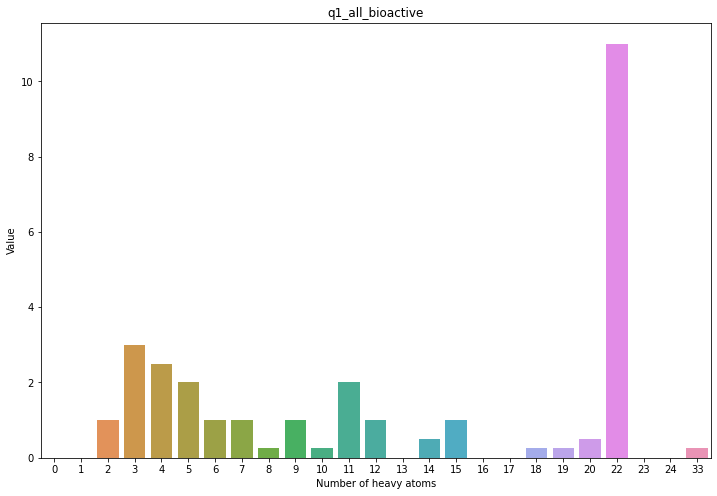

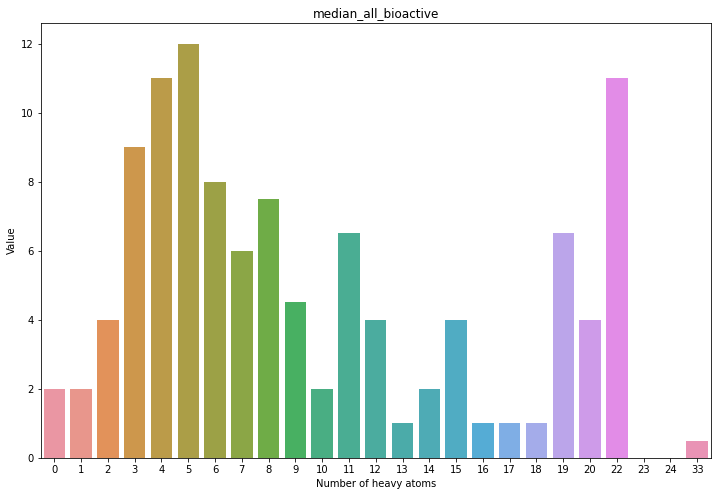

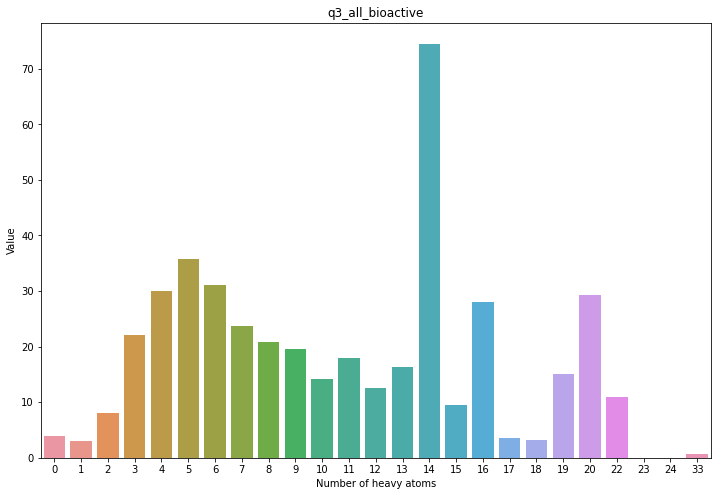

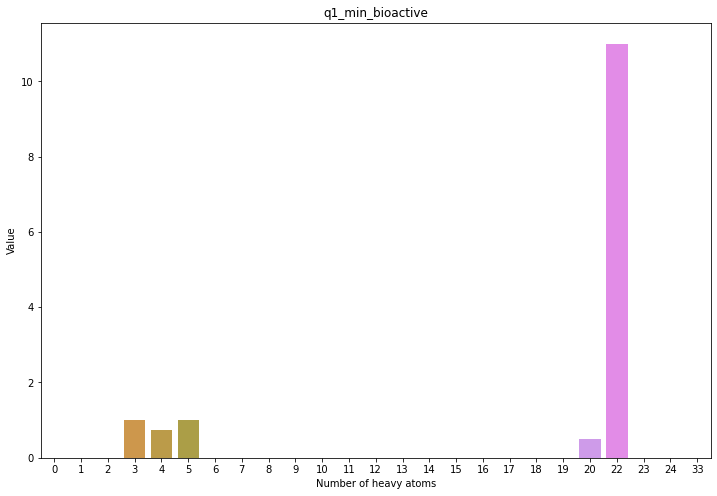

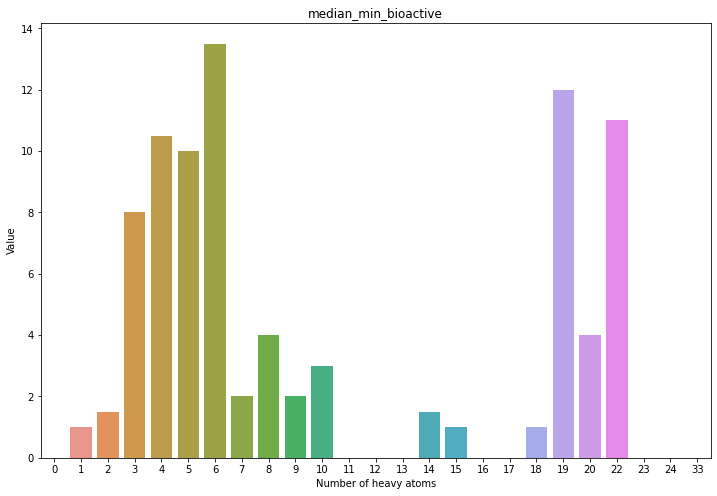

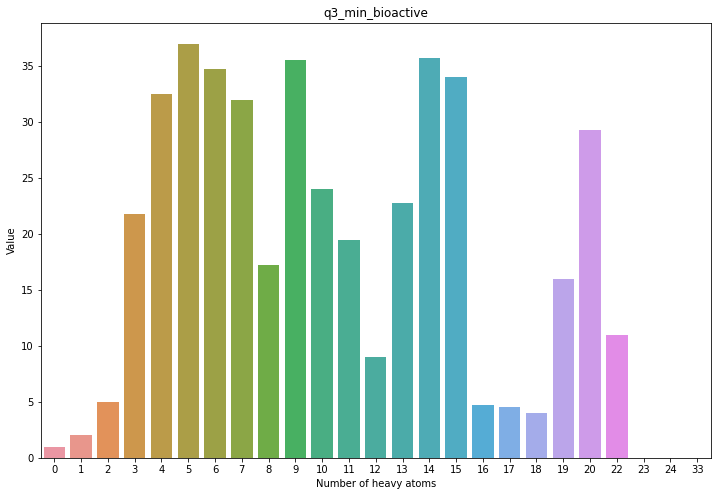

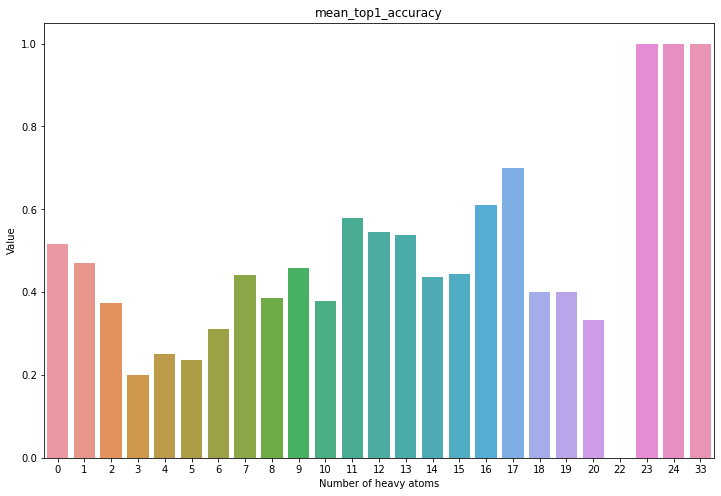

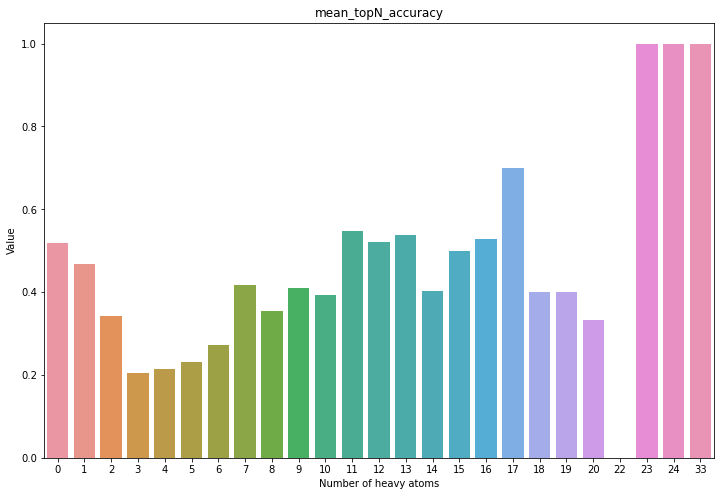

In [6]:
bioactivity_results = {}
for nha in nha_to_smiles :
    nha_results = {}
    for smiles in nha_to_smiles[nha] :
        result = conf_results[smiles]
        nha_results[smiles] = result
      
    if len(nha_results) :
        bioactivity_results[nha] = {}
        
        all_bioactive_ranks = []
        current_mol_results = {}
        included_smiles = []
        for smiles, results_d in nha_results.items() :
            if 'bioactive_ranks' in results_d :
                all_bioactive_ranks.extend([rank for rank in results_d['bioactive_ranks']])
                current_mol_results[smiles] = mol_results[smiles]
                included_smiles.append(smiles)
        
        all_min_bioactive_ranks = []
        top1_accuracies = []
        topn_accuracies = []
        for smiles, results_d in current_mol_results.items() :
            if smiles in included_smiles :
                all_min_bioactive_ranks.append(results_d['min_bioactive_ranks'])
                top1_accuracies.append(results_d['top1_bioactive'])
                topn_accuracies.append(results_d['topN_bioactive'])

        q1, median, q3 = np.quantile(all_bioactive_ranks, [0.25, 0.5, 0.75])
        bioactivity_results[nha]['q1_all_bioactive'] = q1
        bioactivity_results[nha]['median_all_bioactive'] = median
        bioactivity_results[nha]['q3_all_bioactive'] = q3
        
        q1, median, q3 = np.quantile(all_min_bioactive_ranks, [0.25, 0.5, 0.75])
        bioactivity_results[nha]['q1_min_bioactive'] = q1
        bioactivity_results[nha]['median_min_bioactive'] = median
        bioactivity_results[nha]['q3_min_bioactive'] = q3

        bioactivity_results[nha]['mean_top1_accuracy'] = np.mean(top1_accuracies)
        bioactivity_results[nha]['mean_topN_accuracy'] = np.mean(topn_accuracies)
        
nhas = []
metrics = defaultdict(list)
for nha in nha_to_smiles :
    if nha in bioactivity_results :
        nhas.append(nha)
        results = bioactivity_results[nha]
        for metric in results :
            metrics[metric].append(results[metric])
            
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12, 8

for metric in metrics :
    values = metrics[metric]
    sns.barplot(x=nhas, y=values)
    plt.title(metric)
    plt.xlabel('Number of heavy atoms')
    plt.ylabel('Value')
    plt.show()

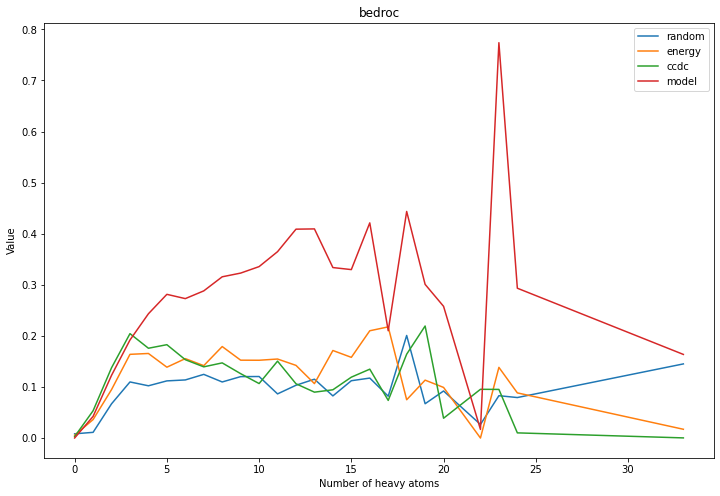

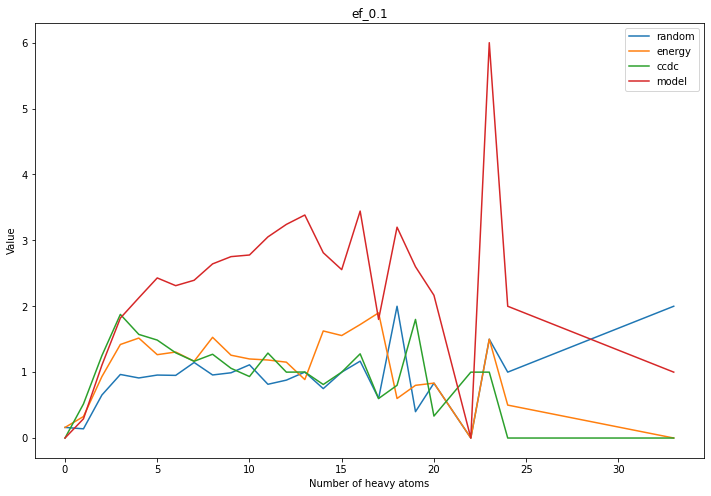

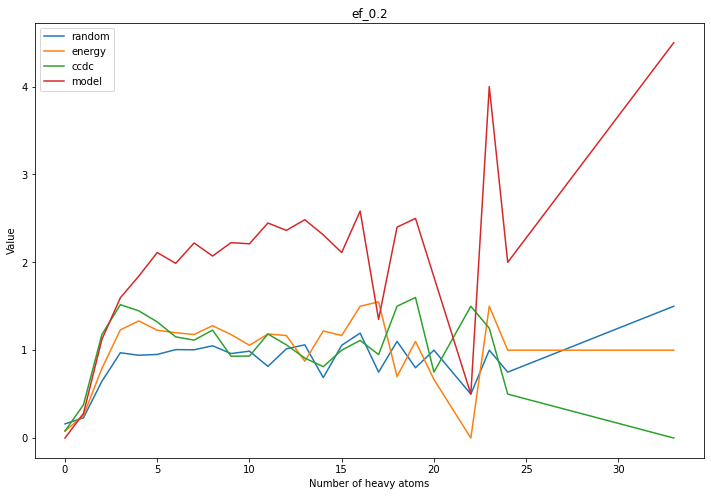

In [7]:
ranking_results = {}
rankers = ['random', 'energy', 'ccdc', 'model']
ef_fractions = [0.1, 0.2]
for nha in nha_to_smiles :
    nha_mol_results = {}
    nhs_conf_results = {}
    for smiles in nha_to_smiles[nha] :
        if 'bedroc' in mol_results[smiles] :
            nha_mol_results[smiles] = mol_results[smiles]
            nhs_conf_results[smiles] = conf_results[smiles]
      
    if len(nha_mol_results) :
        ranking_results[nha] = {}
        
        for ranker in rankers :
            bedrocs = []
            efs = defaultdict(list)
            for smiles, results_d in nha_mol_results.items() :
                if 'bedroc' in results_d :
                    bedrocs.append(results_d['bedroc'][ranker])
                    for fraction in ef_fractions :
                        efs[fraction].append(results_d[f'ef_{fraction}'][ranker])
            ranking_results[nha][ranker] = {}
            ranking_results[nha][ranker]['bedroc'] = np.mean(bedrocs)
            for fraction in ef_fractions :
                ranking_results[nha][ranker][f'ef_{fraction}'] = np.mean(efs[fraction])
        
nhas = []
ranker_metrics = {}
for ranker in rankers :
    ranker_metrics[ranker] = defaultdict(list)
for nha in nha_to_smiles :
    if nha in ranking_results :
        nhas.append(nha)
        results = ranking_results[nha]
        for ranker in rankers :
            for metric in results[ranker] :
                ranker_metrics[ranker][metric].append(results[ranker][metric])
            
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12, 8

for metric in ranker_metrics['random'] :
    for ranker in rankers :
        values = ranker_metrics[ranker][metric]
        sns.lineplot(x=nhas, y=values, label=ranker)
    plt.title(metric)
    plt.xlabel('Number of heavy atoms')
    plt.ylabel('Value')
    plt.show()